In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import qmc

# load PerCX functions
import sys
sys.path.append('../src/percx/')
from percx import *

### Get some temperature training data from CMIP6

In [2]:
# reader header with model names
with open("../input/CMIP6_tas_ssp245.txt") as f:
    models = f.readline().strip().split()[1:]

# read temperature data
dtas_data = np.loadtxt("../input/CMIP6_tas_ssp245.txt", skiprows=1)

In [3]:
dtas_data_gm = np.average(dtas_data,0)
dtas_2100 = dtas_data_gm[-1]

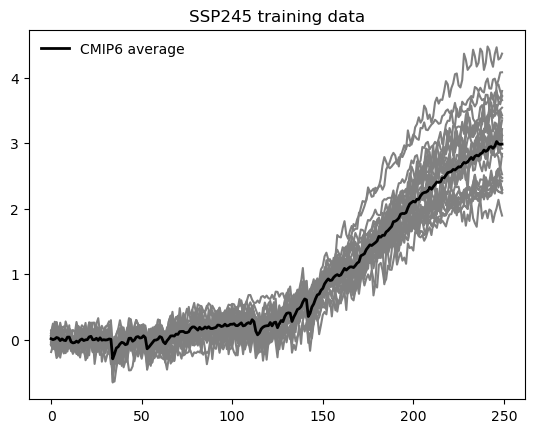

In [4]:
for nm,mname in enumerate(models):
    plt.plot(dtas_data[nm,0:250], color="gray")
plt.plot(dtas_data_gm, color="black", lw=2, label="CMIP6 average")
plt.title("SSP245 training data")
plt.legend(frameon=False)

### "Train the model": Latin-hypercube sampling for coeeficients constrained by AR6 estimates: <br>
1) 4--48 PgC/K at 2100 (CO2: 3-41 + CH4: 1-7) <br>
2) variable CO2/CH4 ratio (5/1 - 100/1) <br>
3) Maximum carbon pool size

In [17]:
scaled_samples[:,3]

array([58.32375004, 81.49532389, 96.87195733, 82.78341232, 24.79499188,
       40.35015349, 61.04583864, 76.91808658, 42.79200022, 58.70636767,
       88.76032517, 52.28260883, 75.20430058, 39.41083074, 54.57911964,
       44.25732511, 22.92612474, 93.12118978, 42.40326853, 13.38052967,
       22.17913757, 36.97112166, 30.86884956, 67.07012315, 14.88361972,
       36.35292824, 64.91913705, 41.36577548, 93.17362164, 83.41040566,
       67.6604983 , 96.6612702 , 19.35211359, 98.09783363, 31.11714065,
       18.91068584, 85.13053612, 15.26986473, 56.23613719, 69.71697849,
       90.49644581, 79.68821611, 91.49606957, 70.92573349, 10.62888224,
       21.87998674, 84.88602567, 86.9621078 , 28.35296951, 81.25551925,
        7.74132974, 83.31062243, 22.99479392, 33.52479652, 23.10723007,
       49.93921579, 58.05225619, 11.61018414, 84.62858571, 27.88463132,
       77.81457689,  9.7108057 , 33.32258839, 16.89912864, 90.0635288 ,
       34.05633217,  8.88040673, 36.23840906, 37.07260511, 37.59

Define initial permafrost carbon pool size

In [6]:
C_init = 1400

In [34]:
# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)

# Define parameter ranges
param_ranges = {
    #"A_CO2": (3, 41),      # Example range
    "A_CH4": (0.5/50000, 7/20000),    # Example range (CO2 sampling will be scaled from CH4 sampling allowing variable ratios between them)
    "tau": (10, 100),      # Example range
    "decay_rate": (0.001,0.002),
    "Cratio": (5,100)      # Variable CO2/CH4 ratio
}

# Number of samples
n_samples = 1000  # Generate extra samples to allow filtering

# Generate LHS samples
sampler = qmc.LatinHypercube(d=len(param_ranges), seed=seed)
lhs_samples = sampler.random(n=n_samples)

# Scale samples to parameter ranges
scaled_samples = qmc.scale(lhs_samples, 
                           [param_ranges[key][0] for key in param_ranges], 
                           [param_ranges[key][1] for key in param_ranges])

# Extract parameter values
A_CH4_samples = scaled_samples[:, 0]
A_CO2_samples = A_CH4_samples * scaled_samples[:,3]  # Scale CO2 from CH4 using sampled variable ratio
tau_samples = scaled_samples[:, 1]
decay_samples = scaled_samples[:, 2]

# Temperature anomaly timeseries (SSP585)
dT = dtas_data_gm
time = np.arange(0, len(dT))

response_range = (dtas_2100*4, dtas_2100*48) # Define the constraint range at the end of the time series

all_responses = [] # Store all responses
all_params = []
valid_responses = []  # Store only valid responses
valid_params = []

for A_CO2, A_CH4, tau, decay in zip(A_CO2_samples, A_CH4_samples, tau_samples, decay_samples):
    response = np.cumsum(PFC_combined_response(dT, time, A_CO2, A_CH4, tau, C_init, decay))
    
    # all responses
    all_responses.append(response)
    all_params.append((A_CO2, A_CH4, tau, decay))

    # constrained responses
    if response_range[0] <= response[-1] <= response_range[1]:
        valid_responses.append(response)
        valid_params.append((A_CO2, A_CH4, tau, decay))

print(f"Total samples generated: {len(all_params)}")
print(f"constrained samples found: {len(valid_params)}")

Total samples generated: 1000
constrained samples found: 776


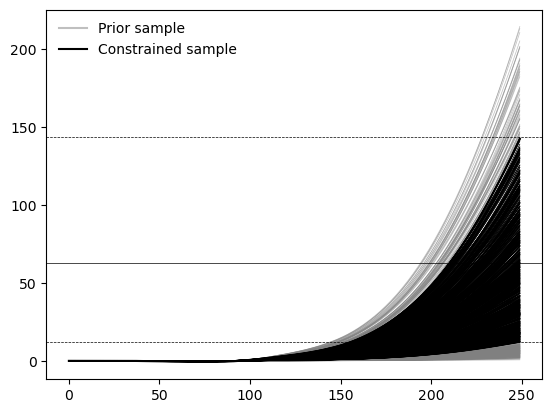

In [35]:
for i in np.arange(0,np.array(all_responses).shape[0]):
    if i == 0: 
        plt.plot(np.array(all_responses)[i,:], color="gray", lw=1.5, alpha=0.5, label="Prior sample")
    else:
        plt.plot(np.array(all_responses)[i,:], color="gray", lw=0.5, alpha=0.5)
for i in np.arange(0,np.array(valid_responses).shape[0]):
    if i == 0: 
        plt.plot(np.array(valid_responses)[i,:], color="black", lw=1.5, label="Constrained sample")
    else:
        plt.plot(np.array(valid_responses)[i,:], color="black", lw=0.5)
plt.axhline(dtas_2100*21, color="black", lw=0.5)
plt.axhline(dtas_2100*4, color="black", lw=0.5, linestyle='--')
plt.axhline(dtas_2100*48, color="black", lw=0.5, linestyle='--')
plt.legend(frameon=False)


### Write valid params into file

In [ ]:
headers = ["A_CO2", "A_CH4", "tau", "decay"]
output_file = "../input/PerCX_valid_params_CMIP6_ssp245.txt"

with open(output_file, "w") as f:
    f.write("\t".join(headers) + "\n")   # write headers
    for row in valid_params:             
        f.write("\t".join(map(str, row)) + "\n")   # write data